# OpenLab - Classification

Fit a classification model to the `2013_Queensland_Floods-ontopic_offtopic.csv` csv file.

Compute the accuracy of the following algorithms:
- GradientBoostedTrees;
- LogisticRegressionWithLBFGS

## Loading all libraries

In [1]:
# import spark
from pyspark import SparkContext
# initialize a new Spark Context to use for the execution of the script
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
# prevent useless logging messages
sc.setLogLevel("ERROR")

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sn
from pyspark.mllib.tree import GradientBoostedTrees
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.classification import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

## Read the input file

In [3]:
# http://kddrtserver14.isti.cnr.it:50070/explorer.html#/hpsa/datasets
server = "14"
all_tweets_raw_rdd = sc.textFile("hdfs://kddrtserver{0}.isti.cnr.it:9000/hpsa/datasets/2013_Queensland_Floods-ontopic_offtopic.csv".format(server))



Check the content of `all_tweets_raw_rdd` and count the number of tweets

In [4]:
all_tweets_raw_rdd.count()

10034

In [5]:
all_tweets_raw_rdd.take(6)

['tweet id, tweet, label',
 '\'296728042179534848\',"@MarkSDobson I always thought that, big lad aint he, must pump some serious lead! Unless he is on the gear like @darrennorton60 #Jabber",off-topic',
 '\'296085045645570048\',"@thamonstar a lot of water moving around and a bit dirty. Probably should give it a miss today",on-topic',
 '\'296811076400603136\',"Craig Thompson to be extradited to Victoria on 149 fraud charges. Oh to be on the plane, with him in handcuffs. #auspol",off-topic',
 '\'295357934387486720\',"Sunshine state, sort your shit out.",off-topic',
 '\'296390762210398210\',"@MarkPhilippi yeah I saw it. He\'s a wanker. Paul Kent was brilliant at that",off-topic']

## Data preparation

Create a HashingTF instance to map tweet's text to a vectors of 10000 features.

In [6]:
tf = HashingTF(numFeatures = 10000)

Preprocess the tweets to transform the texts into vectors and extract the labels. Lastly, creates the LabeledPoints

In [7]:
def proc_raw_tweet(line):
    lp, rp = line.find(","), line.rfind(",")
    tweet, label = line[lp+1:rp], line[rp+1:]

    tweet = re.sub(r"[^a-z#]", " ", tweet.lower())
    tweet_features = tf.transform(tweet.split())
    tweet_label = 1 if label == "on-topic" else 0

    return LabeledPoint(tweet_label, tweet_features)

all_tweets_rdd = all_tweets_raw_rdd\
    .filter(lambda line: line.startswith("'"))\
    .map(proc_raw_tweet)

Check the content of `all_tweets_rdd`

In [8]:
all_tweets_rdd.take(5)

[LabeledPoint(0.0, (10000,[367,777,1136,2098,2744,3185,3317,3387,3870,4199,5016,5167,5554,5608,5840,6470,6826,7061,7495,7981,8308,9852],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (10000,[909,2028,2056,2145,3080,3289,3362,3645,4283,5511,5601,6676,7003,8219,9101,9485],[1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(0.0, (10000,[365,1040,2837,3285,3317,3757,4373,4471,5799,5943,6052,6664,6712,7115,7119,7495,9466],[3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0])),
 LabeledPoint(0.0, (10000,[10,4342,6147,7872,9842,9937],[1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(0.0, (10000,[777,1969,2245,2744,3140,3289,3290,4770,5016,5764,7003,8417,9264,9503,9546],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]

## Split into train and Test sets

Split the dataset into train and test using the proportion 70-30

In [9]:
train_tweets_rdd, test_tweets_rdd = all_tweets_rdd.randomSplit([0.7,0.3])

## Training & Predict

Cache the `train_tweets_rdd` for efficiency purposes. It avoids multiple computations of the same intermediate results by caching them.

In [10]:
train_tweets_rdd.cache()

PythonRDD[5] at RDD at PythonRDD.scala:53

Fetch the test labels to compute the accuracy of the tested models (next)

In [11]:
test_labels_rdd = test_tweets_rdd.map(lambda lp: lp.label)

Define a `confusion_matrix` function to compute and plot the confusion matrix

In [12]:
# auxiliar function
def confusion_matrix(labels, predictions):
    counts_rdd = predictions.zip(labels).map(lambda k: (k,1)).reduceByKey(lambda l,r: l+r)
    counts = dict(((i,j),0) for i in [0,1] for j in [0,1])  # set to 0 all the entries
    counts.update( dict(counts_rdd.collect()) )  # update the non-0 entries
    confusion_matrix = [
        [
            counts[(pred,act)]
            for act in [0,1]
        ] for pred in [0,1]
    ]
    df_cm = pd.DataFrame(confusion_matrix, index = ["Pred 0", "Pred 1"], columns = ["Act 0", "Act 1"])
    sn.heatmap(df_cm, annot=True, fmt='', annot_kws={"size": 14})

### Logistic Regression

Accuracy: 0.8840970350404312


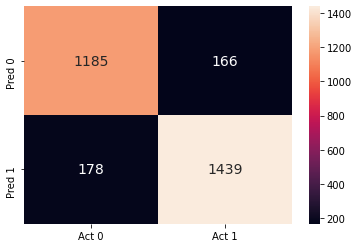

In [13]:
# train 
model = LogisticRegressionWithLBFGS.train(train_tweets_rdd)

# predict
test_predictions_rdd = test_tweets_rdd.map(lambda lp: model.predict(lp.features))

# compute accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(test_labels_rdd.collect(),test_predictions_rdd.collect()))

# plot confusion matrix
confusion_matrix(test_labels_rdd, test_predictions_rdd)

### Gradient Boost Classifier

Accuracy: 0.9477762803234502


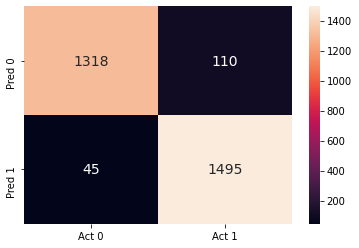

In [14]:
# train 
model = GradientBoostedTrees.trainClassifier(train_tweets_rdd, categoricalFeaturesInfo={}, numIterations=10)

# predict
test_predictions_rdd = model.predict(test_tweets_rdd.map(lambda lp: lp.features))

# compute accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(test_labels_rdd.collect(),test_predictions_rdd.collect()))

# plot confusion matrix
confusion_matrix(test_labels_rdd, test_predictions_rdd)

### WRONG EXAMPLE: the model is trained using also test tweets

Accuracy: 0.9979784366576819


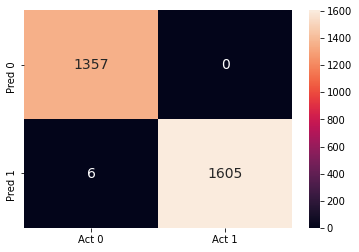

In [15]:
# train 
model = LogisticRegressionWithLBFGS.train(all_tweets_rdd)

# predict
test_predictions_rdd = test_tweets_rdd.map(lambda lp: model.predict(lp.features))

# compute accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(test_labels_rdd.collect(),test_predictions_rdd.collect()))

# plot confusion matrix
confusion_matrix(test_labels_rdd, test_predictions_rdd)